# Monet model test

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports + Define generator

In [2]:
!pip install tensorflow_addons

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import PIL

2021-09-01 11:54:56.798030: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-01 11:54:56.798096: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [5]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Import Cycle GAN trained model

In [6]:
painter = 'ukiyoe'

painter_path = f'/content/drive/MyDrive/Colab Notebooks/Monet_B/output_{painter}/{painter}_weights.h5'


In [7]:
painter_generator = Generator()

In [8]:
painter_generator.load_weights(painter_path)


## Load a photo

In [5]:
IMAGE_SIZE = [256, 256]

image_path = 'test_image.jpg'

image = PIL.Image.open(image_path)

if image.size != (256,256):
    image = image.resize((256,256))

new_image_path = image_path.replace('.', '_new.')

image.save(new_image_path)

In [6]:
input_tensor = tf.io.read_file(new_image_path)

imagetensor = tf.image.decode_jpeg(input_tensor, channels=3)
imagetensor = (tf.cast(imagetensor, tf.float32) / 127.5) - 1

imagetensor = tf.reshape(imagetensor, [*IMAGE_SIZE, 3])
imagetensor = tf.expand_dims(imagetensor, axis=0)

2021-09-01 11:56:24.420981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-01 11:56:24.421053: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-01 11:56:24.421089: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Amine): /proc/driver/nvidia/version does not exist
2021-09-01 11:56:24.421479: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
str(imagetensor.shape)

'(1, 256, 256, 3)'

## Perform a transormation

In [11]:
painter_prediction = painter_generator(imagetensor, training=False)[0].numpy()
painter_prediction = (painter_prediction * 127.5 + 127.5).astype(np.uint8)

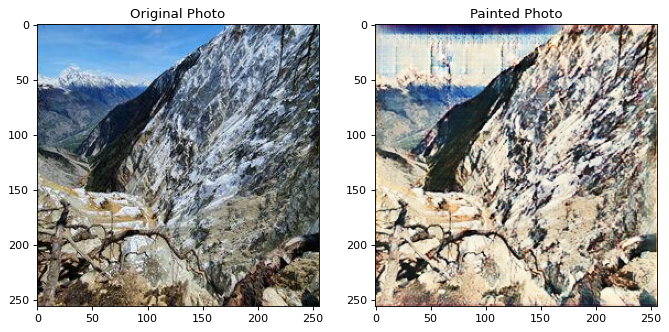

In [12]:
plt.figure(figsize=(10,30), dpi=80)

plt.subplot(321)
plt.title("Original Photo")
plt.imshow(imagetensor[0] * 0.5 + 0.5)

plt.subplot(322)
plt.title("Painted Photo")
plt.imshow(painter_prediction)

In [ ]:
im = PIL.Image.fromarray(monet_prediction)
im.save("/content/drive/MyDrive/Colab Notebooks/Monet_B/images/" + painter + ".jpg")

# Try to upload model to bucket

In [ ]:
cezanne_generator.save('cezanne_generator')

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init


In [ ]:
!gsutil cp -r cezanne_generator gs://bucket-monet-gan